<h1 align="center"> EL7037 </h1>
<h2 align="center"> Tarea 1: Programación Genética </h2>
<h3 align="center"> Problema 2/2 - Proyección de datos </h3>
***

In [2]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import pydotplus
import jpype
import os
from utilsGPalta import *
from tqdm import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# --- Rutas / classpath ---
libGPjar = 'GPaltav2.jar'
jar_path = os.path.join(os.getcwd(), libGPjar)

if not os.path.exists(jar_path):
    raise FileNotFoundError(f"No se encontró el JAR en: {jar_path}")

# Si en el futuro agregas más JARs o carpetas de clases:
# otros = [r"C:\mi\otra\carpeta\clases", r"C:\algo\lib2.jar"]
# classpath = os.pathsep.join([jar_path] + otros)
classpath = jar_path  # por ahora solo tu GPaltav2.jar

# --- Arranque JVM ---
jvmPath = jpype.getDefaultJVMPath()

# OJO: pasar los args desglosados con * y activar convertStrings
jvm_args = [f"-Djava.class.path={classpath}"]

if not jpype.isJVMStarted():
    jpype.startJVM(
        jvmPath,
        *jvm_args,
        convertStrings=True  # <-- clave para que java.lang.String sea str de Python
    )
GP = jpype.JPackage("gpalta")

### Configuración GP

In [52]:
def GP_build(
        n_gen = 100,
        pop_size= 100,
        max_depth= 6,
        nClases= 2,
        prob_mutation= 0.15, 
        prob_crossover= 0.15, 

):
    config = GP.core.Config('Config.txt')
    config.nGenerations   = n_gen    # numero de generaciones
    config.populationSize = pop_size       # tamaño de la poblacion
    config.maxDepth       = max_depth       # profundidad maxima
    config.initialMinDepth= 3        # profundidad minima arboles poblacion inicial
    config.initialMaxDepth= 4        # profundidad maxima arboles poblacion inicial
    config.population     = 'gpalta.multitree.MultiTreePopulation' # Multiarboles
    config.nClasses       = nClases                                      # Dimensionalidad del espacio de salida
    config.fitness        = 'gpalta.core.FitnessSammon'            # criterio de fitness
    config.constLowLimit  = 0
    config.constUpLimit   = 10

    # probability of crossover = upLimitProbCrossOver - 0
    # probability of mutation = upLimitProbMutation - upLimitProbCrossOver
    # probability of reproduction = 1 - upLimitProbMutation
    config.upLimitProbCrossOver = prob_crossover
    config.upLimitProbMutation  = prob_mutation + prob_crossover
    # Más parámetros de configuracion de GP están en los archivos Config.txt y Nodes.txt
    ##### ---- Funciones disponibles --- 
    #['Cos', 'Sin', 'Exponential', 'Square', 'SquareRoot', 'Divide', 'Plus', 'Minus', 'Times']
    selectedFuntion = ['Cos', 'Sin', 'Exponential', 'Square', 'SquareRoot', 'Divide', 'Plus', 'Minus', 'Times']
    setFuntions(selectedFuntion)

    return config

## Extracción base de datos

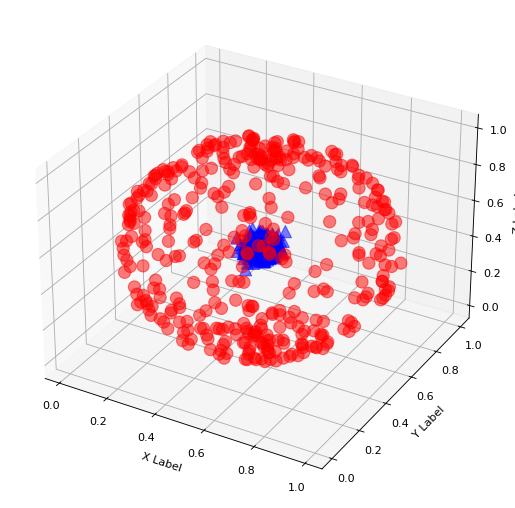

In [53]:
DB = loadmat('BASES.mat')
atom = {'data': DB['Atom'][0][0][0],'class': DB['Atom'][0][0][1]}
derm = {'data': DB['derm'][0][0][0],'class': DB['derm'][0][0][1]}

# ---------------------------- Cambia base de datos -------------------------
X = atom    # atom o derm
# ---------------------------------------------------------------------------

X['data'] = (X['data']-X['data'].min())/(X['data'].max() - X['data'].min())

X_train, X_test, y_train, y_test = train_test_split(X['data'], X['class'], test_size=0.4)
args = [('r', 'o'),('b', '^'),('g','s'),('c','v'),('m','*'),('y','p')]

fig = plt.figure(figsize=(12, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')
for i, cl in enumerate(np.unique(X['class'])):
    idx = np.where(X['class']==cl)[0]
    ax.scatter(X['data'][idx,0], X['data'][idx,1], X['data'][idx,2], c=args[i][0], marker=args[i][1], s=120, alpha=.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

## Main loop GP

In [54]:
def main_loop_gp(
        config
):
    n_axis_proj = config.nClasses
    names   = ['fitness', 'nodes', 'EvalAll',     'tree']
    formats = [np.float64, np.float64,  np.float64,  object]
    dtypes  = list(zip(names, formats))
    dtypes[1] += ((n_axis_proj,),)
    dtypes[2] += ((n_axis_proj, X['data'].shape[0]),)
    dtypes[3] += ((n_axis_proj,),)
    R = np.empty((config.populationSize, config.nGenerations),dtype=dtypes)
    
    evo = GP.core.Evolution(config, py2java(X_train,True),py2java(y_train), py2java(np.zeros((1,len(y_train)))),True)
    evo.eval()
    for gen in tqdm(range(config.nGenerations), desc='Generation'):
        # ------ Condicion de termino GP por tolerancia fitness --------------
        if (evo.evoStats.bestSoFar.readFitness() >= config.stopFitness):
            print('\nObjective reached in generation %d',gen)
            break
        evo.evolve()
        evo.eval()
        for ind in range(config.populationSize):
            R['fitness'][ind,gen] = evo.population.get(ind).readFitness()
            evalTrees             = evo.getRawOutput(evo.population.get(ind), py2java(X['data'],True))
            for n_axis in range(n_axis_proj):
                R['nodes'][ind,gen,n_axis]   = evo.population.get(ind).getTree(n_axis).getSize()
                R['tree'][ind,gen,n_axis]    = evo.population.get(ind).getTree(n_axis)
                R['EvalAll'][ind,gen,n_axis] = java2py(evalTrees.getArray(n_axis))
    return R, evo, evalTrees

In [66]:
n_gen = 500
max_depth = 20
n_axis_proj = 2
config = GP_build(n_gen=n_gen, max_depth=max_depth,nClases=n_axis_proj )
R, evo, evalTrees = main_loop_gp(config)
print('*******************************************************************')
print('                    WINNER TREE, BEST SO FAR ' )
print(' ')
print('FITNESS     : %.5f' %(evo.evoStats.bestSoFar.readFitness()))
print(' ')
for i in range(n_axis_proj):
    print('REDUCED TREE %2d : %s' % (i+1,getReducedAlgebraic(evo.evoStats.bestSoFar.getTree(i))))
    print(' ')
    

Generation: 100%|██████████| 500/500 [07:17<00:00,  1.14it/s]


*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.96046
 


KeyboardInterrupt: 

In [58]:
for i in range(n_axis_proj):
    print('REDUCED TREE %2d : %s' % (i+1,getReducedAlgebraic(evo.evoStats.bestSoFar.getTree(i))))

REDUCED TREE  1 : cos(2*X1) + cos(sin(cos(X1*(X1 + 1)) + cos(sin((cos(X1)*cos(X2) + 5.084947445478106)*cos(X2)))))
REDUCED TREE  2 : X3 + 0.1144785477565745*sin((X3*cos(X2) + 5.084947445478106)*cos(X2)) - 0.1144785477565745*cos(X2) - 0.1144785477565745*cos(sin(X3))


*******************************************************************
                    Tree 1 


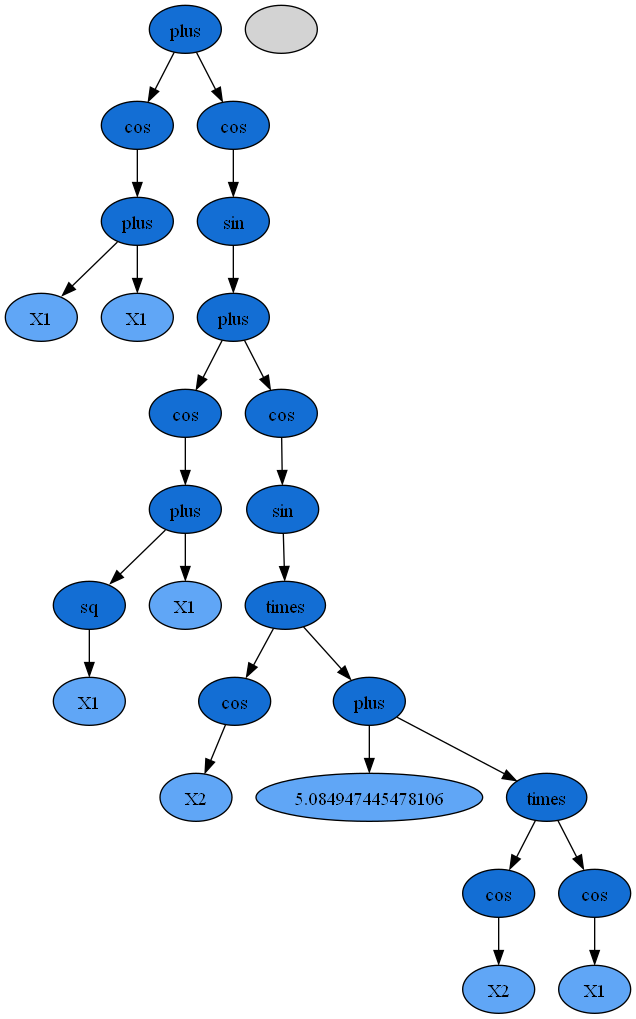

In [59]:
print('*******************************************************************')
print('                    Tree 1 ' )
Image(pydotplus.graphviz.graph_from_dot_data(getTree2plot(evo.evoStats.bestSoFar.getTree(0))).create_png())

*******************************************************************
                    Tree 2 


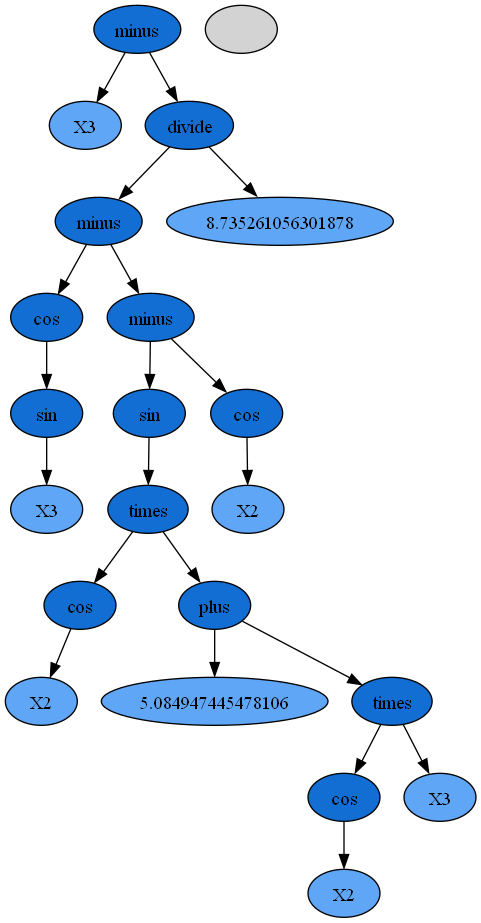

In [60]:
print('*******************************************************************')
print('                    Tree 2 ' )
Image(pydotplus.graphviz.graph_from_dot_data(getTree2plot(evo.evoStats.bestSoFar.getTree(1))).create_png())

## Proyección GP en 2D

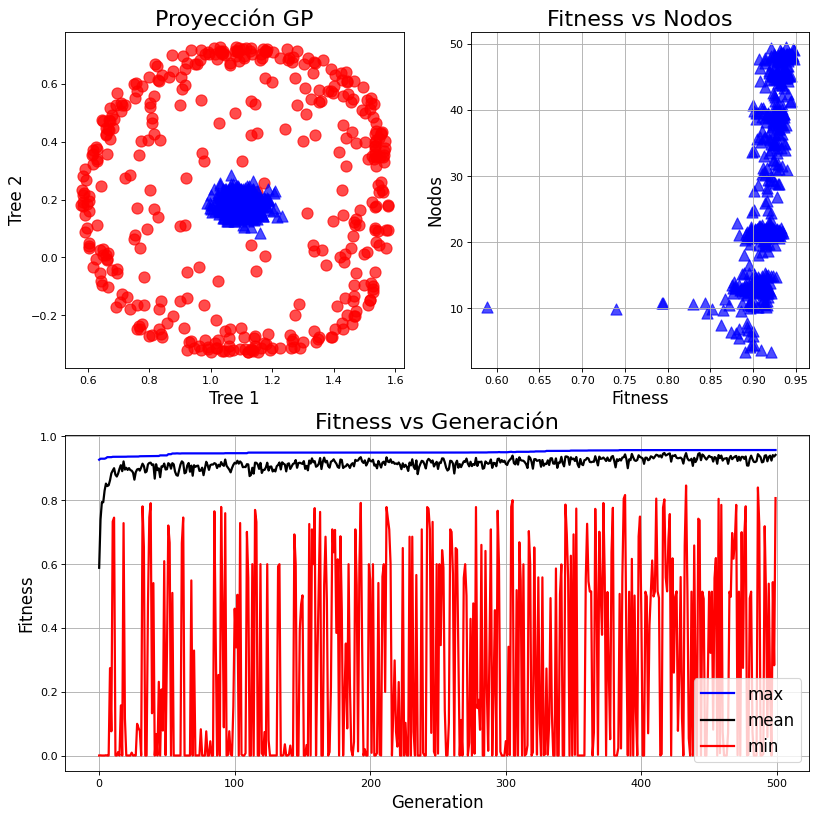

In [61]:
evalTreeBestSoFar = evo.getRawOutput(evo.evoStats.bestSoFar, py2java(X['data'],True))
axis1 = java2py(evalTrees.getArray(0))
axis2 = java2py(evalTrees.getArray(1))

fig = plt.figure(figsize=(12, 12), dpi=80)

ax = fig.add_subplot(2,2,1)
for i, cl in enumerate(np.unique(X['class'])):
    idx = np.where(X['class']==cl)[0]
    ax.scatter(axis1[idx], axis2[idx], c=args[i][0], marker=args[i][1], s=100, alpha=.7)
ax.set_xlabel('Tree 1', fontsize=15)
ax.set_ylabel('Tree 2', fontsize=15)
ax.set_title('Proyección GP',{'fontsize':20})

# Fitness vs Generacion
ax = fig.add_subplot(2,1,2)
ax.plot(np.arange(config.nGenerations), R['fitness'].max(axis=0), 'b', label='max', linewidth=2)
ax.plot(np.arange(config.nGenerations), R['fitness'].mean(axis=0), 'k', label='mean', linewidth=2)
ax.plot(np.arange(config.nGenerations), R['fitness'].min(axis=0), 'r', label='min', linewidth=2)
ax.set_xlabel('Generation',size=15) 
ax.set_ylabel('Fitness',size=15) 
ax.grid()
ax.legend(loc='lower right',fontsize=15)
ax.set_title('Fitness vs Generación',{'fontsize':20})

# Fitness promedio  vs nodos promedios por generación
ax = fig.add_subplot(2,2,2)
ax.scatter(R['fitness'].mean(axis=0), R['nodes'].sum(axis=2).mean(axis=0),
           c=args[1][0], marker=args[1][1], s=100, alpha=.7)
ax.set_ylabel('Nodos',size=15) 
ax.set_xlabel('Fitness',size=15) 
ax.grid()
ax.set_title('Fitness vs Nodos',{'fontsize':20})

plt.show()

### Estimación de métricas de proyección

In [37]:
import metrics #Para ejecutar esta libreria compilar archivos.--> python setup.py build_ext --inplace
from scipy.spatial.distance import pdist, squareform

In [62]:
def mutualdistance(X,Y):
    '''
    X: Vectores en espacio original
    Y: Vectores en espacio proyectado'''
    MX = squareform(pdist(X))
    MY = squareform(pdist(Y))
    return MX, MY

In [63]:
MX, MY = mutualdistance(X['data'], np.c_[axis1,axis2])

In [64]:
K=80
cont  = np.asarray([[k,metrics.cont_c(MX,MY,k)[0]] for k in range(1,K,2)])
trust = np.asarray([[k,metrics.trust_c(MX,MY,k)[0]] for k in range(1,K,2)])
# qm    = np.asarray([[n,k,metrics.qm_c(MX,MY,n,k)[0]] for k in range(5,20,2) for n in range(2,k,2)])
qm = np.asarray([[0.4*k, k,metrics.qm_c(MX,MY,0.4*k,k)[0]] for k in range(5,K,2)]) # n=0.4k

Text(0.5, 1.0, ' Mapping quality')

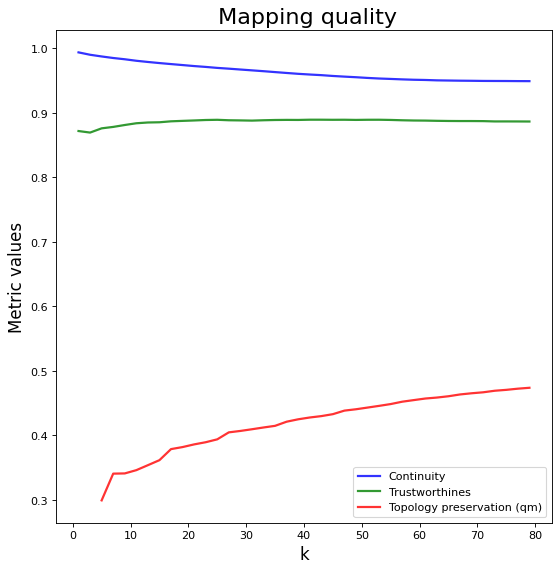

In [65]:
fig = plt.figure(figsize=(8, 8), dpi=80)

ax = fig.add_subplot(1,1,1)
ax.plot(cont[:,0],cont[:,1],'b', label='Continuity', linewidth=2, alpha=0.8)
ax.plot(trust[:,0],trust[:,1],'g', label='Trustworthines', linewidth=2, alpha=0.8)
ax.plot(qm[:,1],qm[:,2],'r', label='Topology preservation (qm)', linewidth=2, alpha=0.8)
ax.set_xlabel('k', fontsize=15)
ax.set_ylabel('Metric values', fontsize=15)
ax.legend()
ax.set_title(' Mapping quality',{'fontsize':20})


In [ ]:
## Finalizar máquina virtual de java
## Ejecute este comando sólo cuando termine la sesión. Al cerrar la máquina virtual, no es posible graficar árboles

# jpype.shutdownJVM()